In [128]:
import pandas as pd
import math as math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('./merged-daily-sales.csv')
unique_product_names = df['Produk'].unique()

'''
Produk Name in Column
['PicsArt PRO' 'Bstation' 'WeTV VIP' 'VIU Premium' 'Prime Video' 'HBO GO'
 'IQIYI VIP' 'Youku' 'Vidio Premier' 'Netflix Premium' 'Disney+ Hostar'
 'Youtube Premium' 'Catchplay+' 'Mango TV' 'Vision+ Sport' 'Apple TV+'
 'VN Pro' 'NordVPN' 'Apple Music' nan 'Capcut Pro' 'Iflix' 'Viki Rakuten'
 'Genflix' 'Microsoft 360' 'Canva PRO' 'Remini Pro' 'Spotify Premium'
 'Mojo Pro' 'Lightroom' 'Mola TV' 'Loklok' 'Gramedia Digital' '1 Tahun'
 'Tiktok Music' 'Vision Sport' 'wtsa' 'Gagaoolala' 'q' 'HBO MAX' 
 'Youku VIP' 'ChatGPT' '1']
'''

product_names = [
 'PicsArt PRO', 'Bstation', 'WeTV VIP', 'VIU Premium', 'Prime Video', 'HBO GO',
 'IQIYI VIP', 'Youku', 'Vidio Premier', 'Netflix Premium', 'Disney+ Hostar',
 'Youtube Premium', 'Catchplay+', 'Mango TV', 'Vision+ Sport', 'Apple TV+',
 'VN Pro', 'NordVPN', 'Apple Music', 'Capcut Pro', 'Iflix', 'Viki Rakuten',
 'Genflix', 'Microsoft 360', 'Canva PRO', 'Remini Pro', 'Spotify Premium',
 'Mojo Pro', 'Lightroom', 'Mola TV', 'Loklok', 'Gramedia Digital', 'Tiktok Music', 
 'Vision Sport', 'Gagaoolala', 'HBO MAX', 'Youku VIP', 'ChatGPT'
]


# Filter out rows in 'Produk' column
product_items = [ 'VIU Premium', 'IQIYI VIP', 'Vidio Premier']

df  = df[df['Produk'].isin(product_items)]

print(len(df))

46122


Summarized Missing Data : Tanggal    1
Produk     0
Harga      1
dtype: int64
Deleted Data:2


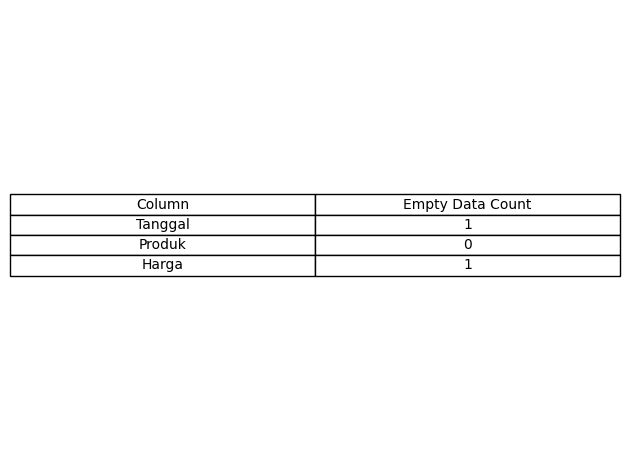

In [129]:
#Check Missing Data
def dropna_columns():
    global df
    null_data = pd.DataFrame({
        "Column": df.columns,
        "Empty Data Count": df.isnull().sum().values
    })
    print(f"Summarized Missing Data : {df.isnull().sum()}")


    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')


    ax.table(cellText=null_data.values, colLabels=null_data.columns, loc='center',cellLoc='center')

    fig.tight_layout()

    initial_rows = len(df)

    df = df.dropna()

    # df.to_csv('no_missing_data.csv', index=False)

    print(f"Deleted Data:{initial_rows - len(df)}")
    
dropna_columns()

In [130]:
# --- 2. Data Preprocessing ---
# Convert 'Tanggal' to datetime objects
# This is crucial for correct chronological sorting and time-based operations.
# We use dayfirst=True if your date format is DD-MM-YYYY. Adjust if it's MM-DD-YYYY.
try:
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True)
except ValueError:
    print("Attempting to parse Tanggal with default format (MM-DD-YYYY or YYYY-MM-DD).")
    df['Tanggal'] = pd.to_datetime(df['Tanggal'])
    
# Ensure 'Harga' is a numeric type
df['Harga'] = pd.to_numeric(df['Harga'], errors='coerce') # 'coerce' will turn non-numeric into NaN

# Data Aggregation

In [131]:
df = df.groupby(['Tanggal', 'Produk']).agg(
    total_revenue=('Harga', 'sum'),
    # transaction_count=('Harga', 'count'),
    # average_price=('Harga', 'mean')
).reset_index()
df = df.sort_values(by=['Produk', 'Tanggal']).reset_index(drop=True)
# df.to_csv('processed_sales_data.csv', index=False)

# Time Feature Engineering

In [132]:
# df['month'] = df['Tanggal'].dt.month
# df['day'] = df['Tanggal'].dt.day
# df['day_of_week'] = df['Tanggal'].dt.dayofweek

# df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
# df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# # DayOfWeek
# df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
# df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int) 


# Rolling Statistics

In [133]:
window_sizes = [10]
target_col = 'total_revenue'

for window in window_sizes:
    grouped_product_data = df.groupby('Produk')[target_col]

    df[f'{target_col}_ema_{window}'] = grouped_product_data.shift(1).ewm(span=window, adjust=False, min_periods=1).mean()

    # df[f'{target_col}_roll_std_{window}'] = grouped_product_data.transform(
    #     lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
    # )
    # df[f'{target_col}_roll_min_{window}'] = grouped_product_data.transform(
    #     lambda x: x.shift(1).rolling(window=window, min_periods=1).min()
    # )
    # df[f'{target_col}_roll_max_{window}'] = grouped_product_data.transform(
    #     lambda x: x.shift(1).rolling(window=window, min_periods=1).max()
    # )

# Lag

In [134]:
lag_periods = [1]

for lag in lag_periods:
    df[f'{target_col}_lag_{lag}'] = df.groupby('Produk')[target_col].shift(lag)

# Create Specific Target Variable For 1 Month Ahead

In [135]:
# forecast_horizon_days = 30
# df['target_revenue_1_month_ahead'] = df.groupby('Produk')[target_col].shift(-forecast_horizon_days)

# Remove NaN Data To Ensure Data Cleanliness

Summarized Missing Data : Tanggal                 0
Produk                  0
total_revenue           0
total_revenue_ema_10    1
total_revenue_lag_1     3
dtype: int64
Deleted Data:3


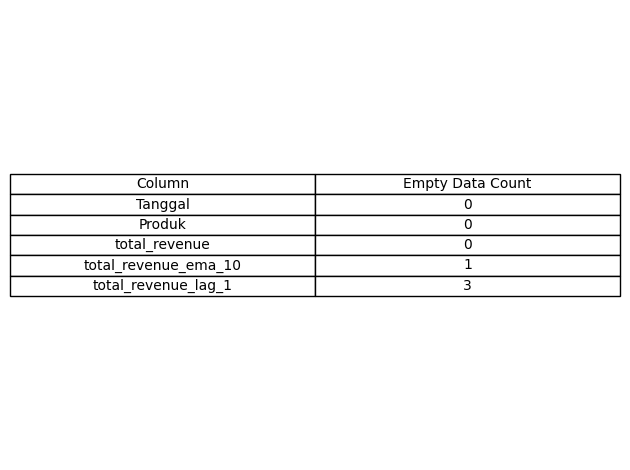

In [136]:


# df = df.dropna(subset=['target_price_1_month_ahead'])
dropna_columns()

# Encode Product

In [137]:
# le = LabelEncoder()
# df['produk_encoded'] = le.fit_transform(df['Produk'])

# Labeling For Classification


In [138]:
def classify_revenue(predicted_revenue):
    if predicted_revenue >= 1000000:
        return "Good for Sale"
    elif 500000 <= predicted_revenue < 1000000:
        return "Normal Sale"
    else: # predicted_revenue < 500000
        return "Bad for Sale"
    
df['revenue_class'] = df['total_revenue'].apply(classify_revenue)

C:\Users\User\AppData\Local\Temp\ipykernel_13504\2788228842.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['revenue_class'] = df['total_revenue'].apply(classify_revenue)


# Split The Data

In [139]:
start_date = pd.to_datetime('2025-01-01')

df.to_csv("final_dataset.csv", index=False)

# data_feb_apr_2025 = df[
#     (df['Tanggal'] >= start_date)
# ]

# df = df[
#   (df['Tanggal'] < start_date)
# ]

# print(f"Jumlah Data Feb-Apr 2025: {len(data_feb_apr_2025)}")
# print(f"Jumlah Data Jan 2024 - Jan 2025: {len(df)}")

# data_feb_apr_2025.to_csv('data_test.csv', index=False)
# df.to_csv('data_training.csv', index=False)

print(df.dtypes)


Tanggal                 datetime64[ns]
Produk                          object
total_revenue                  float64
total_revenue_ema_10           float64
total_revenue_lag_1            float64
revenue_class                   object
dtype: object
